In [1]:
!pip install -U huggingface_hub constants pandas matplotlib flash_attn imageio decord

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 702.8 kB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 827.1 kB/s eta 0:00:00 0:00:01
INFO: pip is looking at multiple versions of constants to determine which version is compatible with other requirements. This could take a while.
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 1.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 417.5/417.5 kB 9.7 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 11.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 24.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.4/315.4 kB 20.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.6/13.6 MB 19.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
!mkdir pretrained && cd pretrained
!huggingface-cli download --resume-download --local-dir-use-symlinks False OpenGVLab/InternVL2-8B --local-dir InternVL2-8B

/usr/local/lib/python3.10/dist-packages/huggingface_hub/commands/download.py:132: FutureWarning: Ignoring --local-dir-use-symlinks. Downloading to a local directory does not use symlinks anymore.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Fetching 26 files:   0%|                                 | 0/26 [00:00<?, ?it/s]Downloading 'README.md' to 'InternVL2-8B/.cache/huggingface/download/README.md.0cce1c1628271be22543fb971765a8fa31b4b7bb.incomplete'

README.md:   0%|                                    | 0.00/53.2k [00:00<?, ?B/s]Downloading 'configuration_internlm2.py' to 'InternVL2-8B/.cache/huggingface/download/configuration_internlm2.py.282b13b1e2066ecc074ecae87b35a19d251f0ed7.incomplete'
README.md: 100%|███████████████████████████|

In [4]:
import re
import constants
import os
import requests
import pandas as pd
import multiprocessing
import time
from time import time as timer
from tqdm import tqdm
import numpy as np
from pathlib import Path
from functools import partial
import requests
import urllib
from PIL import Image

def create_placeholder_image(image_save_path):
    try:
        placeholder_image = Image.new('RGB', (100, 100), color='black')
        placeholder_image.save(image_save_path)
    except Exception as e:
        return

def download_image(image_link, save_folder, retries=3, delay=3):
    if not isinstance(image_link, str):
        return

    filename = Path(image_link).name
    image_save_path = os.path.join(save_folder, filename)

    if os.path.exists(image_save_path):
        return

    for _ in range(retries):
        try:
            urllib.request.urlretrieve(image_link, image_save_path)
            return
        except:
            time.sleep(delay)
    
    create_placeholder_image(image_save_path) #Create a black placeholder image for invalid links/images

def download_images(image_links, download_folder, allow_multiprocessing=True):
    if not os.path.exists(download_folder):
        os.makedirs(download_folder)

    if allow_multiprocessing:
        download_image_partial = partial(
            download_image, save_folder=download_folder, retries=3, delay=3)

        with multiprocessing.Pool(64) as pool:
            list(tqdm(pool.imap(download_image_partial, image_links), total=len(image_links)))
            pool.close()
            pool.join()
    else:
        for image_link in tqdm(image_links, total=len(image_links)):
            download_image(image_link, save_folder=download_folder, retries=3, delay=3)
        

In [7]:
DATASET_FOLDER = 'dataset/'
train = pd.read_csv(os.path.join(DATASET_FOLDER, 'train.csv'))
test = pd.read_csv(os.path.join(DATASET_FOLDER, 'test.csv'))

download_images(train['image_link'], 'dataset/train')
download_images(test['image_link'], 'dataset/test')

100%|██████████| 131187/131187 [02:54<00:00, 751.35it/s] 


                     Entity Name   Count
0                    item_weight  102786
1                    item_volume    7682
2                        voltage    9466
3                        wattage    7755
4  maximum_weight_recommendation    3263
5                         height   43597
6                          depth   45127
7                          width   44183


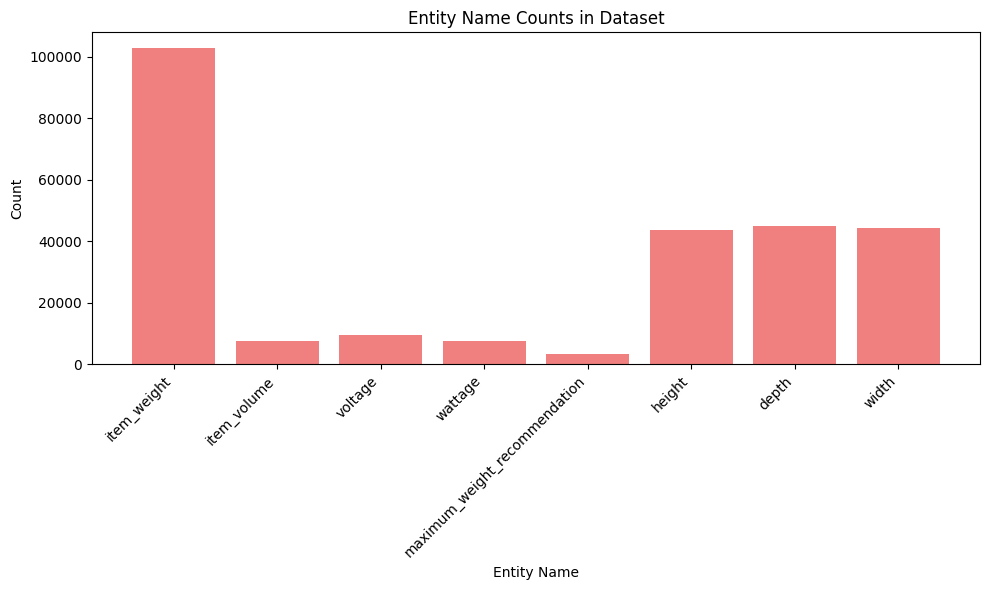

In [10]:
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt

# Function to count the occurrences of entity names from CSV
def count_entity_names(csv_path):
    # Load the CSV file
    data = pd.read_csv(csv_path)
    
    # Assuming the entity names are in a column called 'entity_name'
    entity_names = data['entity_name']
    
    # Count the occurrences of each entity_name
    entity_counts = Counter(entity_names)
    
    return entity_counts

# Function to plot the entity counts
def plot_entity_counts(entity_counts):
    # Extract keys and values from the dictionary
    entity_names = list(entity_counts.keys())
    counts = list(entity_counts.values())

    # Plot the data
    plt.figure(figsize=(10, 6))
    plt.bar(entity_names, counts, color='lightcoral')

    # Rotate x-axis labels to avoid overlap
    plt.xticks(rotation=45, ha='right', fontsize=10)

    # Add titles and labels
    plt.title('Entity Name Counts in Dataset')
    plt.xlabel('Entity Name')
    plt.ylabel('Count')

    # Adjust layout to prevent clipping
    plt.tight_layout()

    # Show the plot
    plt.show()

# Display entity counts in tabular form without using external tools
def display_entity_counts(entity_counts):
    # Create a DataFrame for better display
    df_counts = pd.DataFrame(list(entity_counts.items()), columns=['Entity Name', 'Count'])
    return df_counts

csv_path = 'dataset/train.csv'  # Path to your actual CSV file
# Using the CSV to count entities and create a table
entity_counts = count_entity_names(csv_path)
entity_counts_table = display_entity_counts(entity_counts)
print(entity_counts_table)

# Display the DataFrame as a table



# Example usage


# Using the CSV to count entities and plot
entity_counts = count_entity_names(csv_path)
plot_entity_counts(entity_counts)


                     Entity Name  Count
0                         height  32282
1                          width  26931
2                          depth  28146
3                    item_weight  22032
4  maximum_weight_recommendation   7028
5                        wattage   5447
6                        voltage   5488
7                    item_volume   3833


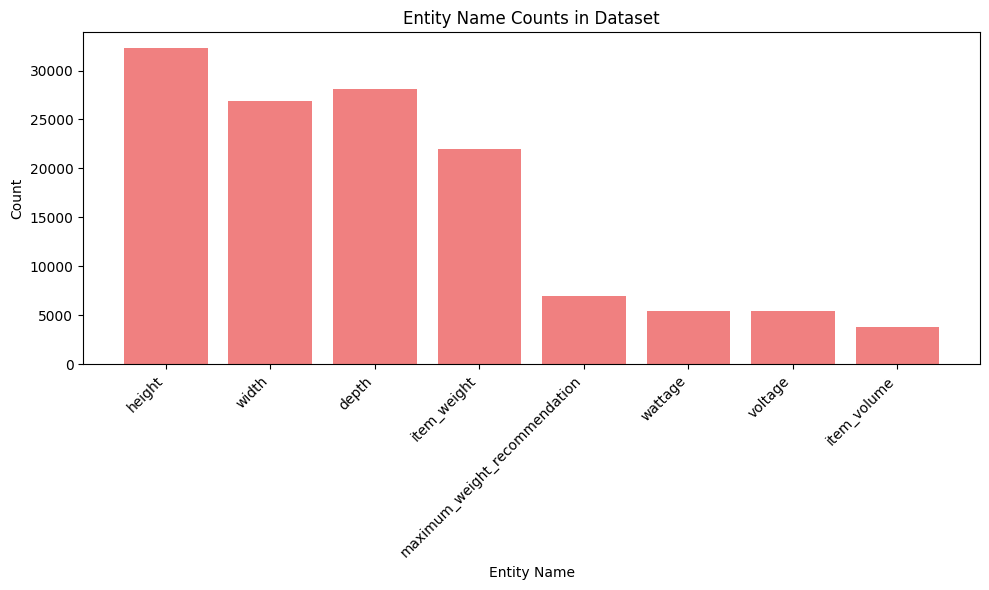

In [11]:
csv_path = 'dataset/test.csv'  # Path to your actual CSV file

entity_counts = count_entity_names(csv_path)
entity_counts_table = display_entity_counts(entity_counts)
print(entity_counts_table)

# Using the CSV to count entities and plot
entity_counts = count_entity_names(csv_path)
plot_entity_counts(entity_counts)

In [9]:
import pandas as pd
import json
import os
import re
from tqdm import tqdm

def convert_entity_value_to_float(text):
    """
    Convert all numerical values in the text to floats.
    """
    matches = re.findall(r'\d+(?:\.\d+)?', text)
    
    if matches:
        numbers = [float(match) for match in matches]
        parts = re.split(r'(\d+(?:\.\d+)?)', text)
        result_parts = []
        num_idx = 0
        for part in parts:
            if re.match(r'\d+(?:\.\d+)?', part):
                result_parts.append(str(numbers[num_idx]))
                num_idx += 1
            else:
                result_parts.append(part)
        return ''.join(result_parts).strip()
    else:
        return text

def create_internvl_dataset_with_metadata(csv_file, image_dir, output_jsonl_file, entity_unit_map, test_csv=None, total=None):
    """
    Function to create a dataset in JSONL format compatible with InternVL, 
    including metadata and using only the entity value in the assistant's response.
    If test_csv is provided, samples are proportionally taken from the train set.
    """
    # Load the train data
    data = pd.read_csv(csv_file)

    # If test_csv is provided, load the test set and calculate proportions
    if test_csv:
        test_data = pd.read_csv(test_csv)
        entity_proportions = test_data['entity_name'].value_counts(normalize=True)

        # If total is specified, sample proportionally from the train data
        if total:
            sampled_data = pd.DataFrame()
            for entity_name, proportion in entity_proportions.items():
                num_samples = int(proportion * total)
                entity_samples = data[data['entity_name'] == entity_name].sample(n=num_samples, replace=False, random_state=42)
                sampled_data = pd.concat([sampled_data, entity_samples])
        else:
            sampled_data = data  # If no total, use full dataset
    else:
        sampled_data = data  # If no test_csv, use full dataset

    # Shuffle the sampled data to randomize the order
    sampled_data = sampled_data.sample(frac=1, random_state=42)

    # Create the meta file structure
    meta_info = {
        "amazon-product-dataset": {
            "root": image_dir,
            "annotation": output_jsonl_file,
            "data_augment": False,
            "repeat_time": 1,
            "length": len(sampled_data)
        }
    }

    jsonl_entries = []

    # Iterate over each row in the sampled data with tqdm for progress bar
    for idx, row in tqdm(sampled_data.iterrows(), total=len(sampled_data), desc="Processing data"):
        # Get the local image path
        image_filename = os.path.basename(row["image_link"])
        local_image_path = os.path.join(image_dir, image_filename)
        
        # Convert entity_value to "float number unit"
        entity_value_converted = convert_entity_value_to_float(str(row['entity_value']))

        # Retrieve the available units for the current entity_name
        entity_name = row['entity_name']
        if entity_name in entity_unit_map:
            units = ', '.join(sorted(entity_unit_map[entity_name]))
            question = f'What is the {entity_name} of the item in one of the following units ({units})?'
        else:
            question = f'What is the {entity_name} of the item?'

        entry = {
            "id": idx,
            "image": local_image_path,
            "conversations": [
                {
                    "from": "human",
                    "value": f"<image>\n{question}"
                },
                {
                    "from": "gpt",
                    "value": f"{entity_value_converted}"
                }
            ]
        }
        
        jsonl_entries.append(entry)

    # Define the path to save the meta file
    meta_file = output_jsonl_file.replace(".jsonl", "_meta.json")

    # Save the meta information
    with open(meta_file, 'w') as meta_f:
        json.dump(meta_info, meta_f, indent=4)
    
    print(f"Meta file saved to {meta_file}")

    # Write the JSONL data to a file
    with open(output_jsonl_file, 'w') as f:
        for entry in jsonl_entries:
            json.dump(entry, f)
            f.write('\n')

    print(f"Dataset saved to {output_jsonl_file}")

# Example usage:
csv_file = '/workspace/dataset/train.csv'  # Path to your CSV file
image_dir = '/workspace/dataset/train/'  # Directory where your images are stored
output_jsonl_file = '/workspace/dataset/train_data.jsonl'  # Path to save the output JSONL file
test_csv = '/workspace/dataset/test.csv'  # Optional: Path to your test CSV file, if needed

# Define the entity-unit mapping
entity_unit_map = {
    'width': {'centimetre', 'foot', 'inch', 'metre', 'millimetre', 'yard'},
    'depth': {'centimetre', 'foot', 'inch', 'metre', 'millimetre', 'yard'},
    'height': {'centimetre', 'foot', 'inch', 'metre', 'millimetre', 'yard'},
    'item_weight': {'gram', 'kilogram', 'microgram', 'milligram', 'ounce', 'pound', 'ton'},
    'maximum_weight_recommendation': {'gram', 'kilogram', 'microgram', 'milligram', 'ounce', 'pound', 'ton'},
    'voltage': {'kilovolt', 'millivolt', 'volt'},
    'wattage': {'kilowatt', 'watt'},
    'item_volume': {'centilitre', 'cubic foot', 'cubic inch', 'cup', 'decilitre', 'fluid ounce', 'gallon', 'imperial gallon', 'litre', 'microlitre', 'millilitre', 'pint', 'quart'}
}

# Create the dataset with metadata, proportional sampling based on test set, and total = 50,000
create_internvl_dataset_with_metadata(csv_file, image_dir, output_jsonl_file, entity_unit_map, test_csv=test_csv, total=10000)


Processing data: 100%|██████████| 9996/9996 [00:00<00:00, 20684.02it/s]


Meta file saved to /workspace/dataset/train_data_meta.json
Dataset saved to /workspace/dataset/train_data.jsonl


In [15]:
csv_file = '/workspace/dataset/test.csv'  # Path to your CSV file
image_dir = '/workspace/dataset/train/'
output_jsonl_file = '/workspace/dataset/test_data.jsonl'


NameError: name 'create_internvl_dataset_with_metadata' is not defined

In [13]:
import json
import pandas as pd
from collections import Counter

def verify_distribution(jsonl_file, test_csv):
    """
    Verifies the distribution of `entity_name` in the generated JSONL file against the 
    proportions in the test set.
    
    Parameters:
    - jsonl_file: Path to the generated JSONL file.
    - test_csv: Path to the test set CSV file to compare against.
    
    Returns:
    - A DataFrame with the entity name, expected proportion, actual proportion, and the difference.
    """
    # Load the test CSV to calculate expected proportions
    test_data = pd.read_csv(test_csv)
    test_entity_counts = test_data['entity_name'].value_counts(normalize=True)

    # Read the JSONL file and count occurrences of each `entity_name`
    entity_name_counts = Counter()
    
    with open(jsonl_file, 'r') as f:
        for line in f:
            entry = json.loads(line)
            # Extract the entity name from the human question
            question = entry['conversations'][0]['value']
            # We assume the question is formatted as: "What is the <entity_name> of the item"
            entity_name = question.split('What is the ')[1].split(' of')[0]
            entity_name_counts[entity_name] += 1

    # Convert the entity counts into proportions
    total_count = sum(entity_name_counts.values())
    actual_proportions = {entity: count / total_count for entity, count in entity_name_counts.items()}

    # Create a DataFrame to compare expected and actual proportions
    comparison_data = {
        'entity_name': [],
        'expected_proportion': [],
        'actual_proportion': [],
        'difference': []
    }

    for entity_name, expected_proportion in test_entity_counts.items():
        actual_proportion = actual_proportions.get(entity_name, 0)
        difference = actual_proportion - expected_proportion
        
        comparison_data['entity_name'].append(entity_name)
        comparison_data['expected_proportion'].append(expected_proportion)
        comparison_data['actual_proportion'].append(actual_proportion)
        comparison_data['difference'].append(difference)

    comparison_df = pd.DataFrame(comparison_data)
    return comparison_df

# Example usage:
jsonl_file = 'dataset/train_data.jsonl'  # Path to the generated JSONL file
test_csv = 'dataset/test.csv'  # Path to the test CSV file

# Verify the distribution and display the result
distribution_comparison_df = verify_distribution(jsonl_file, test_csv)
print(distribution_comparison_df)


                     entity_name  expected_proportion  actual_proportion  \
0                         height             0.246076           0.246080   
1                          depth             0.214549           0.214557   
2                          width             0.205287           0.205296   
3                    item_weight             0.167943           0.167953   
4  maximum_weight_recommendation             0.053572           0.053564   
5                        voltage             0.041833           0.041823   
6                        wattage             0.041521           0.041523   
7                    item_volume             0.029218           0.029202   

   difference  
0    0.000003  
1    0.000008  
2    0.000009  
3    0.000010  
4   -0.000008  
5   -0.000010  
6    0.000002  
7   -0.000015  


In [ ]:
import json
import random
import os
from tqdm import tqdm  # Import tqdm for the progress bar

def split_dataset(jsonl_file, train_output_file, val_output_file, train_meta_file, val_meta_file, split_ratio=0.8, seed=42):
    """
    Function to split a JSONL dataset and its meta information into training and validation sets.
    
    Parameters:
    - jsonl_file: Path to the input JSONL file containing the full dataset.
    - train_output_file: Path to save the training split JSONL file.
    - val_output_file: Path to save the validation split JSONL file.
    - train_meta_file: Path to save the training meta JSON file.
    - val_meta_file: Path to save the validation meta JSON file.
    - split_ratio: Ratio of training data (default is 0.8 for an 80/20 split).
    - seed: Random seed for reproducibility.
    """
    # Set the random seed for reproducibility
    random.seed(seed)

    # Read all the data from the JSONL file
    with open(jsonl_file, 'r') as f:
        data = [json.loads(line) for line in f]

    # Shuffle the data to ensure randomness
    random.shuffle(data)

    # Calculate the number of training samples
    train_size = int(len(data) * split_ratio)

    # Split the data into training and validation sets
    train_data = data[:train_size]
    val_data = data[train_size:]

    # Write the training data to the train_output_file with progress bar
    with open(train_output_file, 'w') as f_train:
        for entry in tqdm(train_data, desc="Writing training data"):
            json.dump(entry, f_train)
            f_train.write('\n')

    # Write the validation data to the val_output_file with progress bar
    with open(val_output_file, 'w') as f_val:
        for entry in tqdm(val_data, desc="Writing validation data"):
            json.dump(entry, f_val)
            f_val.write('\n')

    # Handle meta files for training and validation datasets
    root_dir = os.path.dirname(jsonl_file)

    # Create meta information for training dataset
    train_meta = {
        "your-custom-dataset-train": {
            "root": root_dir,
            "annotation": train_output_file,
            "data_augment": False,
            "repeat_time": 1,
            "length": len(train_data)
        }
    }

    # Create meta information for validation dataset
    val_meta = {
        "your-custom-dataset-val": {
            "root": root_dir,
            "annotation": val_output_file,
            "data_augment": False,
            "repeat_time": 1,
            "length": len(val_data)
        }
    }

    # Save the training meta file
    with open(train_meta_file, 'w') as f_train_meta:
        json.dump(train_meta, f_train_meta, indent=4)

    # Save the validation meta file
    with open(val_meta_file, 'w') as f_val_meta:
        json.dump(val_meta, f_val_meta, indent=4)

    print(f"Training dataset saved to {train_output_file}")
    print(f"Validation dataset saved to {val_output_file}")
    print(f"Training meta file saved to {train_meta_file}")
    print(f"Validation meta file saved to {val_meta_file}")
    print(f"Training samples: {len(train_data)}, Validation samples: {len(val_data)}")


# Example usage:
jsonl_file = 'dataset/train_data.jsonl'  # Path to your full dataset JSONL file
train_output_file = 'dataset/train_split.jsonl'  # Output path for training data
val_output_file = 'dataset/val_split.jsonl'  # Output path for validation data
train_meta_file = 'dataset/train_meta.json'  # Output path for training meta file
val_meta_file = 'dataset/val_meta.json'  # Output path for validation meta file

# Call the function to split the dataset (80/20 split by default)
split_dataset(jsonl_file, train_output_file, val_output_file, train_meta_file, val_meta_file, split_ratio=0.8)


In [14]:
!git clone https://github.com/OpenGVLab/InternVL.git

Cloning into 'InternVL'...
remote: Enumerating objects: 2474, done.
remote: Counting objects: 100% (932/932), done.
remote: Compressing objects: 100% (169/169), done.
remote: Total 2474 (delta 790), reused 784 (delta 753), pack-reused 1542 (from 1)
Receiving objects: 100% (2474/2474), 36.31 MiB | 53.66 MiB/s, done.
Resolving deltas: 100% (1515/1515), done.


In [3]:
%cd /workspace/InternVL/internvl_chat

/workspace/InternVL/internvl_chat


/usr/local/lib/python3.10/dist-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [4]:
# %cd /workspace/InternVL
# !pip install -r requirements.txt
# %cd /workspace/InternVL/internvl_chat
!pip install -e .

Obtaining file:///workspace/InternVL/internvl_chat
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Using cached transformers-4.37.2-py3-none-any.whl.metadata (129 kB)
  Using cached tokenizers-0.15.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.7 kB)
  Using cached sentencepiece-0.1.99-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (7.7 kB)
  Using cached shortuuid-1.0.13-py3-none-any.whl.metadata (5.8 kB)
  Using cached accelerate-0.34.2-py3-none-any.whl.metadata (19 kB)
  Using cached peft-0.12.0-py3-none-any.whl.metadata (13 kB)
  Using cached bitsandbytes-0.41.0-py3-none-any.whl.metadata (9.8 kB)
  Using cached pydantic-2.9.1-py3-none-any.whl.metadata (146 kB)
  Using cached markdown2-2.5.0-py2.py3-none-any.whl.metadata (2.2 kB)
  Using cached scikit_learn-1.5.2-cp310-cp310-ma

In [ ]:
import torch
torch.cuda.empty_cache()

import gc
gc.collect()

In [1]:
! GPUS=4 PER_DEVICE_BATCH_SIZE=8 sh /workspace/InternVL/internvl_chat/shell/internvl2.0/2nd_finetune/internvl2_8b_internlm2_7b_dynamic_res_2nd_finetune_lora.sh

+ GPUS=4
+ BATCH_SIZE=64
+ PER_DEVICE_BATCH_SIZE=8
+ GRADIENT_ACC=2
+ pwd
+ export PYTHONPATH=:/workspace
+ export MASTER_PORT=34229
+ export TF_CPP_MIN_LOG_LEVEL=3
+ export LAUNCHER=pytorch
+ OUTPUT_DIR=work_dirs/internvl_chat_v2_0/internvl2_8b_internlm2_7b_dynamic_res_2nd_finetune_lora
+ [ ! -d work_dirs/internvl_chat_v2_0/internvl2_8b_internlm2_7b_dynamic_res_2nd_finetune_lora ]
+ + torchrun --nnodes=1 --node_rank=0 --master_addr=127.0.0.1 --nproc_per_node=4 --master_port=34229 /workspace/InternVL/internvl_chat/internvl/train/internvl_chat_finetune.py --model_name_or_path /workspace/pretrained/InternVL2-8B --conv_style internlm2-chat --output_dir work_dirs/internvl_chat_v2_0/internvl2_8b_internlm2_7b_dynamic_res_2nd_finetune_lora --meta_path /workspace/dataset/train_data_meta.json --overwrite_output_dir True --force_image_sizetee 448 -a --max_dynamic_patch work_dirs/internvl_chat_v2_0/internvl2_8b_internlm2_7b_dynamic_res_2nd_finetune_lora/training_log.txt 6
 --down_sample_ratio 0.5

In [ ]:
cd /workspace/InternVL/internvl_chat

In [ ]:
pip install -e .

In [ ]:
# !GPUS=1 sh /workspace/Int
# ernVL/internvl_chat/evaluate.sh work_dirs/internvl_chat_v2_0/internvl2_2b_internlm2_1_8b_dynamic_res_2nd_finetune_lora /workspace/work_dirs/internvl_chat_v2_0/internvl2_8b_internlm2_7b_dynamic_res_2nd_finetune_lora amazon-product-dataset

In [2]:
!python /workspace/InternVL/internvl_chat/tools/merge_lora.py   /workspace/work_dirs/internvl_chat_v2_0/internvl2_8b_internlm2_7b_dynamic_res_2nd_finetune_lora  /workspace/work_dirs/internvl_chat_v2_0/internvl2_2b_internlm2_1_8b_dynamic_res_2nd_finetune_lora_amazon_merge/

Loading model...
trainable params: 37,748,736 || all params: 7,775,531,008 || trainable%: 0.4855
Loading checkpoint shards: 100%|██████████████████| 4/4 [00:08<00:00,  2.18s/it]
Loading tokenizer...
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Saving model...
Saving tokenizer...
Done!


In [3]:
cp /workspace/pretrained/InternVL2-8B/*.py /workspace/work_dirs/internvl_chat_v2_0/internvl2_2b_internlm2_1_8b_dynamic_res_2nd_finetune_lora_amazon_merge/

In [4]:
cp /workspace/pretrained/InternVL2-8B/config.json /workspace/work_dirs/internvl_chat_v2_0/internvl2_2b_internlm2_1_8b_dynamic_res_2nd_finetune_lora_amazon_merge/

# Infernce

In [5]:
import torch
torch.cuda.empty_cache()

import gc
gc.collect()

0

In [2]:
!pip install transformers accelerate timm einops flash_attn decord sentencepiece

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 794.9 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 12.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 324.4/324.4 kB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 17.0 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 20.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 782.7/782.7 kB 17.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 435.0/435.0 kB 21.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 15.6 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 23.3.1 -> 24.2
[notice] To update, run: python -m pip install --upgrade pip


In [7]:
import numpy as np
import torch
import torchvision.transforms as T
from decord import VideoReader, cpu
from PIL import Image
from torchvision.transforms.functional import InterpolationMode
from transformers import AutoModel, AutoTokenizer

IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD = (0.229, 0.224, 0.225)

def build_transform(input_size):
    MEAN, STD = IMAGENET_MEAN, IMAGENET_STD
    transform = T.Compose([
        T.Lambda(lambda img: img.convert('RGB') if img.mode != 'RGB' else img),
        T.Resize((input_size, input_size), interpolation=InterpolationMode.BICUBIC),
        T.ToTensor(),
        T.Normalize(mean=MEAN, std=STD)
    ])
    return transform

def find_closest_aspect_ratio(aspect_ratio, target_ratios, width, height, image_size):
    best_ratio_diff = float('inf')
    best_ratio = (1, 1)
    area = width * height
    for ratio in target_ratios:
        target_aspect_ratio = ratio[0] / ratio[1]
        ratio_diff = abs(aspect_ratio - target_aspect_ratio)
        if ratio_diff < best_ratio_diff:
            best_ratio_diff = ratio_diff
            best_ratio = ratio
        elif ratio_diff == best_ratio_diff:
            if area > 0.5 * image_size * image_size * ratio[0] * ratio[1]:
                best_ratio = ratio
    return best_ratio

def dynamic_preprocess(image, min_num=1, max_num=12, image_size=448, use_thumbnail=False):
    orig_width, orig_height = image.size
    aspect_ratio = orig_width / orig_height

    # calculate the existing image aspect ratio
    target_ratios = set(
        (i, j) for n in range(min_num, max_num + 1) for i in range(1, n + 1) for j in range(1, n + 1) if
        i * j <= max_num and i * j >= min_num)
    target_ratios = sorted(target_ratios, key=lambda x: x[0] * x[1])

    # find the closest aspect ratio to the target
    target_aspect_ratio = find_closest_aspect_ratio(
        aspect_ratio, target_ratios, orig_width, orig_height, image_size)

    # calculate the target width and height
    target_width = image_size * target_aspect_ratio[0]
    target_height = image_size * target_aspect_ratio[1]
    blocks = target_aspect_ratio[0] * target_aspect_ratio[1]

    # resize the image
    resized_img = image.resize((target_width, target_height))
    processed_images = []
    for i in range(blocks):
        box = (
            (i % (target_width // image_size)) * image_size,
            (i // (target_width // image_size)) * image_size,
            ((i % (target_width // image_size)) + 1) * image_size,
            ((i // (target_width // image_size)) + 1) * image_size
        )
        # split the image
        split_img = resized_img.crop(box)
        processed_images.append(split_img)
    assert len(processed_images) == blocks
    if use_thumbnail and len(processed_images) != 1:
        thumbnail_img = image.resize((image_size, image_size))
        processed_images.append(thumbnail_img)
    return processed_images

def load_image(image_file, input_size=448, max_num=12):
    image = Image.open(image_file).convert('RGB')
    transform = build_transform(input_size=input_size)
    images = dynamic_preprocess(image, image_size=input_size, use_thumbnail=True, max_num=max_num)
    pixel_values = [transform(image) for image in images]
    pixel_values = torch.stack(pixel_values)
    return pixel_values



In [10]:
entity_unit_map = {
    'width': {'centimetre', 'foot', 'inch', 'metre', 'millimetre', 'yard'},
    'depth': {'centimetre', 'foot', 'inch', 'metre', 'millimetre', 'yard'},
    'height': {'centimetre', 'foot', 'inch', 'metre', 'millimetre', 'yard'},
    'item_weight': {'gram',
        'kilogram',
        'microgram',
        'milligram',
        'ounce',
        'pound',
        'ton'},
    'maximum_weight_recommendation': {'gram',
        'kilogram',
        'microgram',
        'milligram',
        'ounce',
        'pound',
        'ton'},
    'voltage': {'kilovolt', 'millivolt', 'volt'},
    'wattage': {'kilowatt', 'watt'},
    'item_volume': {'centilitre',
        'cubic foot',
        'cubic inch',
        'cup',
        'decilitre',
        'fluid ounce',
        'gallon',
        'imperial gallon',
        'litre',
        'microlitre',
        'millilitre',
        'pint',
        'quart'}
}

In [12]:
# If you have an 80G A100 GPU, you can put the entire model on a single GPU.
# Otherwise, you need to load a model using multiple GPUs, please refer to the `Multiple GPUs` section.
path = '/workspace/work_dirs/internvl_chat_v2_0/internvl2_2b_internlm2_1_8b_dynamic_res_2nd_finetune_lora_amazon_merge'
model = AutoModel.from_pretrained(
    path,
    torch_dtype=torch.bfloat16,
    low_cpu_mem_usage=True,
    use_flash_attn=True,
    trust_remote_code=True).eval().cuda()
tokenizer = AutoTokenizer.from_pretrained(path, trust_remote_code=True, use_fast=False)

generation_config = dict(max_new_tokens=1024, do_sample=False)


# batch inference, single image per sample (单图批处理)
pixel_values = load_image('/workspace/dataset/train/617Tl40LOXL.jpg', max_num=12).to(torch.bfloat16).cuda()
# pixel_values2 = load_image('./examples/image2.jpg', max_num=12).to(torch.bfloat16).cuda()
# num_patches_list = [pixel_values1.size(0), pixel_values2.size(0)]
num_patches_list = [pixel_values.size(0)]


allowed_units = {unit for entity in entity_unit_map for unit in entity_unit_map[entity]}

# Extract the allowed units for 'item_weight'
item_weight_units = ', '.join(entity_unit_map['item_weight'])

# Modify the question string by replacing the placeholder with the actual units
questions = [f'<image>\nitem height in {item_weight_units}']

responses = model.batch_chat(tokenizer, pixel_values,
                             num_patches_list=num_patches_list,
                             questions=questions,
                             generation_config=generation_config)
for question, response in zip(questions, responses):
    print(f'User: {question}\nAssistant: {response}')


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


User: <image>
item height in gram, ton, microgram, kilogram, pound, ounce, milligram
Assistant: 1400.0 milligram


In [13]:
import re
import json
import torch
from PIL import Image
from transformers import AutoModel, AutoTokenizer

# Function to load the train.jsonl file and extract image paths, questions, and ground truths
def load_data_from_jsonl(jsonl_file):
    ground_truths = {}
    image_files = []
    questions_list = []
    
    with open(jsonl_file, 'r') as f:
        for line in f:
            data = json.loads(line)
            image_path = data['image']  # Extract the image file path
            image_files.append(image_path)  # Add image file path to the list
            
            conversation = data['conversations']
            for item in conversation:
                if item['from'] == 'gpt':  # Extract the ground truth from gpt's response
                    image_name = image_path.split('/')[-1]  # Get the image file name
                    ground_truths[image_name] = item['value']
                elif item['from'] == 'human':  # Extract the question from the human input
                    # Extract the allowed units for 'item_weight'
                    key = item['value'].split('\n')[1]  # This will give 'item_weight'

                    # Now use this key to get the corresponding units from entity_unit_map
                    item_weight_units = ', '.join(entity_unit_map[key])                    
                    
                    # Modify the question string by replacing the placeholder with the actual units
                    question = f' in one of the following ({item_weight_units}) unit'
                    questions_list.append('What is ' + item['value'] + ' of the item' + question)
    
    return image_files, questions_list, ground_truths

# Function to load and preprocess the image (based on your earlier code)
def load_image(image_file, input_size=448, max_num=12):
    image = Image.open(image_file).convert('RGB')
    transform = build_transform(input_size=input_size)
    images = dynamic_preprocess(image, image_size=input_size, use_thumbnail=True, max_num=max_num)
    pixel_values = [transform(image) for image in images]
    pixel_values = torch.stack(pixel_values)
    return pixel_values

def convert_and_append_unit(text):
    # Search for a number (with optional decimal) in the text
    match = re.search(r'\d+(\.\d+)?', text)
    
    if match:
        # Convert the matched number to float
        number = float(match.group())
        # Extract the unit (which is the last part of the string)
        unit = text.split()[-1]
        # Return the formatted result
        return f"{number} {unit}"
    else:
        # If no number is found, return just the unit
        unit = text.split()[-1] if len(text.split()) > 0 else None
        return unit

# Function to compare predictions with ground truth and calculate accuracy
def compare_predictions_with_ground_truth(predictions, ground_truths):
    correct = 0
    total = len(predictions)
    
    for image_name, predicted_weight in predictions.items():
        ground_truth_weight = ground_truths.get(image_name, None)
        if ground_truth_weight is not None:
            if predicted_weight.strip().lower() == ground_truth_weight.strip().lower():
                correct += 1
                print(f'  Predicted: {predicted_weight}')
                print(f'  Ground Truth: {ground_truth_weight}')                
            else:
                print(f'Mismatch for {image_name}:')
                print(f'  Predicted: {predicted_weight}')
                print(f'  Ground Truth: {ground_truth_weight}')
        else:
            print(f'No ground truth available for {image_name}')
    
    accuracy = correct / total if total > 0 else 0
    print(f'Accuracy: {accuracy * 100:.2f}%')

# Assuming model and tokenizer have been defined and loaded
def run_inference(model, tokenizer, image_files, questions):
    predictions = {}
    
    for image_file, question in zip(image_files, questions):
        # print(question)
        pixel_values = load_image(image_file, max_num=12).to(torch.bfloat16).cuda()
        responses = model.batch_chat(tokenizer, pixel_values, num_patches_list=[pixel_values.size(0)], generation_config=generation_config, questions=[question])
        
        # Extract prediction and associate it with the image
        predicted_weight = responses[0]  # Assuming a single response per image
        image_name = image_file.split('/')[-1]  # Extracting image file name
        # convert_and_append_unit = lambda text: f"{float(re.search(r'\d+(\.\d+)?', text).group())} {text.split()[-1]}" if re.search(r'\d+(\.\d+)?', text) else None
        
        predictions[image_name] = convert_and_append_unit(predicted_weight)
    
    return predictions


# # Function to compare predictions with ground truth and calculate accuracy
# def compare_predictions_with_ground_truth(predictions, ground_truths):
#     correct = 0
#     total = len(predictions)
    
#     for prediction in predictions:
#         image_name = prediction['image_name']
#         predicted_weight = prediction['predicted_weight']
        
#         # Retrieve ground truth for the image
#         ground_truth_weight = ground_truths.get(image_name, None)
        
#         if ground_truth_weight is not None:
#             if predicted_weight.strip().lower() == ground_truth_weight.strip().lower():
#                 correct += 1
#                 print(f'  Predicted: {predicted_weight}')
#                 print(f'  Ground Truth: {ground_truth_weight}')
#             else:
#                 print(f'Mismatch for {image_name}:')
#                 print(f'  Predicted: {predicted_weight}')
#                 print(f'  Ground Truth: {ground_truth_weight}')
#         else:
#             print(f'No ground truth available for {image_name}')
    
#     accuracy = correct / total if total > 0 else 0
#     print(f'Accuracy: {accuracy * 100:.2f}%')

# # Function to run inference on the model and store results in a list
# def run_inference(model, tokenizer, image_files, questions):
#     predictions = []
    
#     for image_file, question in zip(image_files, questions):
#         # print(question)
#         pixel_values = load_image(image_file, max_num=12).to(torch.bfloat16).cuda()
#         responses = model.batch_chat(tokenizer, pixel_values, num_patches_list=[pixel_values.size(0)], generation_config=generation_config, questions=[question])
        
#         # Extract prediction and associate it with the image
#         predicted_weight = responses[0]  # Assuming a single response per image
#         image_name = image_file.split('/')[-1]  # Extracting image file name
        
#         # Append the result as a dictionary to the predictions list
#         predictions.append({
#             'image_name': image_name,
#             'predicted_weight': predicted_weight
#         })
    
#     return predictions

# Load image paths, questions, and ground truths from the provided JSONL file
image_files, questions_list, ground_truths = load_data_from_jsonl('/workspace/dataset/.jsonl')

# Load model and tokenizer (from earlier)
path = '/workspace/work_dirs/internvl_chat_v2_0/internvl2_2b_internlm2_1_8b_dynamic_res_2nd_finetune_lora_amazon_merge'
model = AutoModel.from_pretrained(
    path,
    torch_dtype=torch.bfloat16,
    low_cpu_mem_usage=True,
    use_flash_attn=True,
    trust_remote_code=True).eval().cuda()
tokenizer = AutoTokenizer.from_pretrained(path, trust_remote_code=True, use_fast=False)

# Run inference to get predictions
predictions = run_inference(model, tokenizer, image_files, questions_list)

# Compare predictions with ground truth and calculate accuracy
compare_predictions_with_ground_truth(predictions, ground_truths)


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


  Predicted: 13.0 gram
  Ground Truth: 13.0 gram
  Predicted: 1000.0 milligram
  Ground Truth: 1000.0 milligram
  Predicted: 264.0 gram
  Ground Truth: 264.0 gram
Mismatch for 81nyHjPXg-L.jpg:
  Predicted: 26.0 kilogram
  Ground Truth: 34.0 kilogram
  Predicted: 72.57 gram
  Ground Truth: 72.57 gram
Accuracy: 80.00%
